# Economic Cycles TDA

Introduccion...

## Librerías a usar

Para este proyecto se hará uso de librerías estandar para análisis de datos y Machine Learning, como lo son `numpy`, `scikit-learn`, `pandas` y `matplotlib`, entre otras. Adicionalmente se hará uso de la librería `giotto-tda` para la generacion de complejos y el cálculo de diagramas de persistencia, además de otras tareas propias del Análisis Topológico de Datos.

In [1]:
# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Machine Learning y preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Topological Data Analysis
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.time_series import SingleTakensEmbedding
from gtda.time_series import TakensEmbedding
from gtda.time_series import takens_embedding_optimal_parameters

# Auxiliar
import math
import copy

## Datos (Economía Colombiana)

En este análisis se utilizan series temporales macroeconómicas que describen la evolución de la economía colombiana a lo largo del tiempo. La base de datos ha sido construida a partir de diferentes bases oficiales, como lo son el DANE, el Banco de la república, entre otros.

In [230]:
# Importacion de datos
ruta = "../data/base_macro_con_pib.csv"
data = pd.read_csv(ruta)

# Convertir columna de fechas a tipo datetime
data["Fecha"] = pd.to_datetime(data["Fecha"])

print(f"Primera fecha: {data['Fecha'][0]} y última fecha {data['Fecha'][len(data) - 1]}")

# Definirla como índice temporal
data.set_index("Fecha", inplace=True)

data.head()

Primera fecha: 2008-02-01 00:00:00 y última fecha 2025-01-01 00:00:00


,precio_brent_usd,valor_colcap,Indic_de_precios_al_consumidor,Indic_seguimiento_economia,Indic_tasa_de_cambio_real,tasa_desempleo,pib
Fecha,,,,,,,
2008-02-01,100.10,914.90,66.50,75.6,103.65,12.19,151082
2008-03-01,100.30,889.28,67.04,74.3,102.22,11.34,151161
2008-04-01,111.36,985.95,67.51,75.4,99.87,11.08,151246
2008-05-01,127.78,1019.78,68.14,74.6,98.29,10.81,151841
2008-06-01,139.83,945.31,68.73,75.0,94.62,11.41,152455


In [3]:
# Información general del DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2008-02-01 to 2025-01-01
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   precio_brent_usd                204 non-null    float64
 1   valor_colcap                    204 non-null    float64
 2   Indic_de_precios_al_consumidor  204 non-null    float64
 3   Indic_seguimiento_economia      204 non-null    float64
 4   Indic_tasa_de_cambio_real       204 non-null    float64
 5   tasa_desempleo                  204 non-null    float64
 6   pib                             204 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 12.8 KB


In [4]:
# Información estadística del DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
precio_brent_usd,204.0,78.530735,24.331209,26.35,59.2500,76.085,101.1150,139.83
valor_colcap,204.0,1407.582108,242.941117,788.73,1248.2700,1391.575,1604.0050,1901.83
Indic_de_precios_al_consumidor,204.0,95.192255,21.711590,66.50,77.6000,92.650,105.4925,146.24
Indic_seguimiento_economia,204.0,99.733333,14.736058,74.20,87.7000,101.200,110.1750,124.60
Indic_tasa_de_cambio_real,204.0,124.594902,21.648171,92.83,101.8975,128.430,139.4875,175.73
tasa_desempleo,204.0,11.045686,2.272996,7.56,9.4975,10.650,11.9600,21.97
pib,204.0,201730.818627,30353.421413,150420.00,177580.5000,204654.000,220642.5000,252690.00


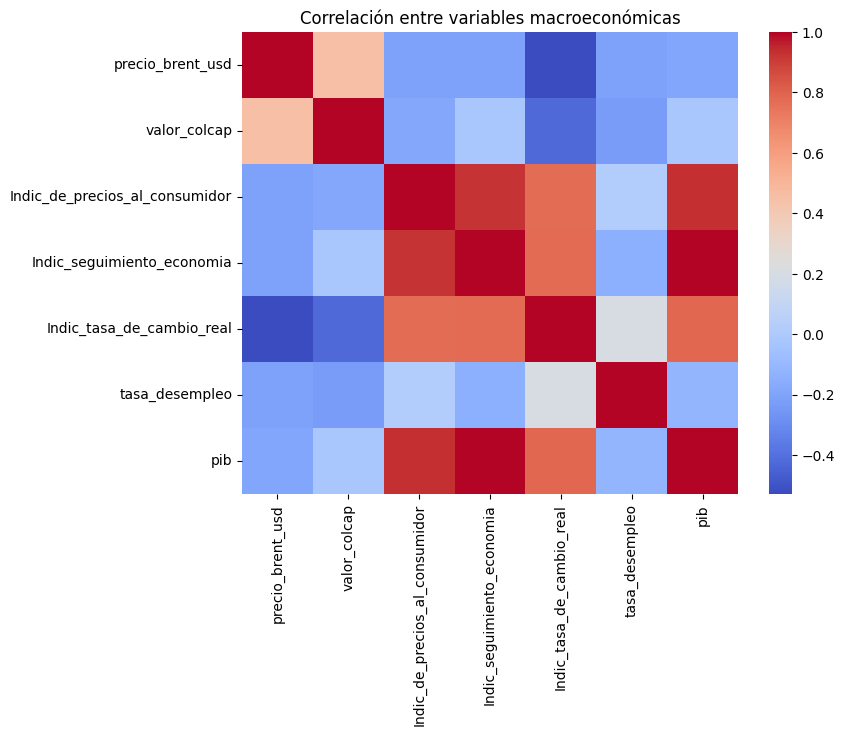

In [5]:
# Tabla de correlaciones
corr = data.corr()
plt.figure(figsize=(8,6)) 
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlación entre variables macroeconómicas")
plt.show()

## Transformación de los datos [Escalamiento]

En esta sección vamos a proceder con una tranformación de escala en los datos, en este caso una normalización.

La Normalización tiene como intención generar un conjunto de datos que mantenga las relaciones entre variables sin importar la escala de estas, mapeando todos los valores del DataFrame a valores entre [0, 1].

In [6]:
# Normalizacion
scaler = MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

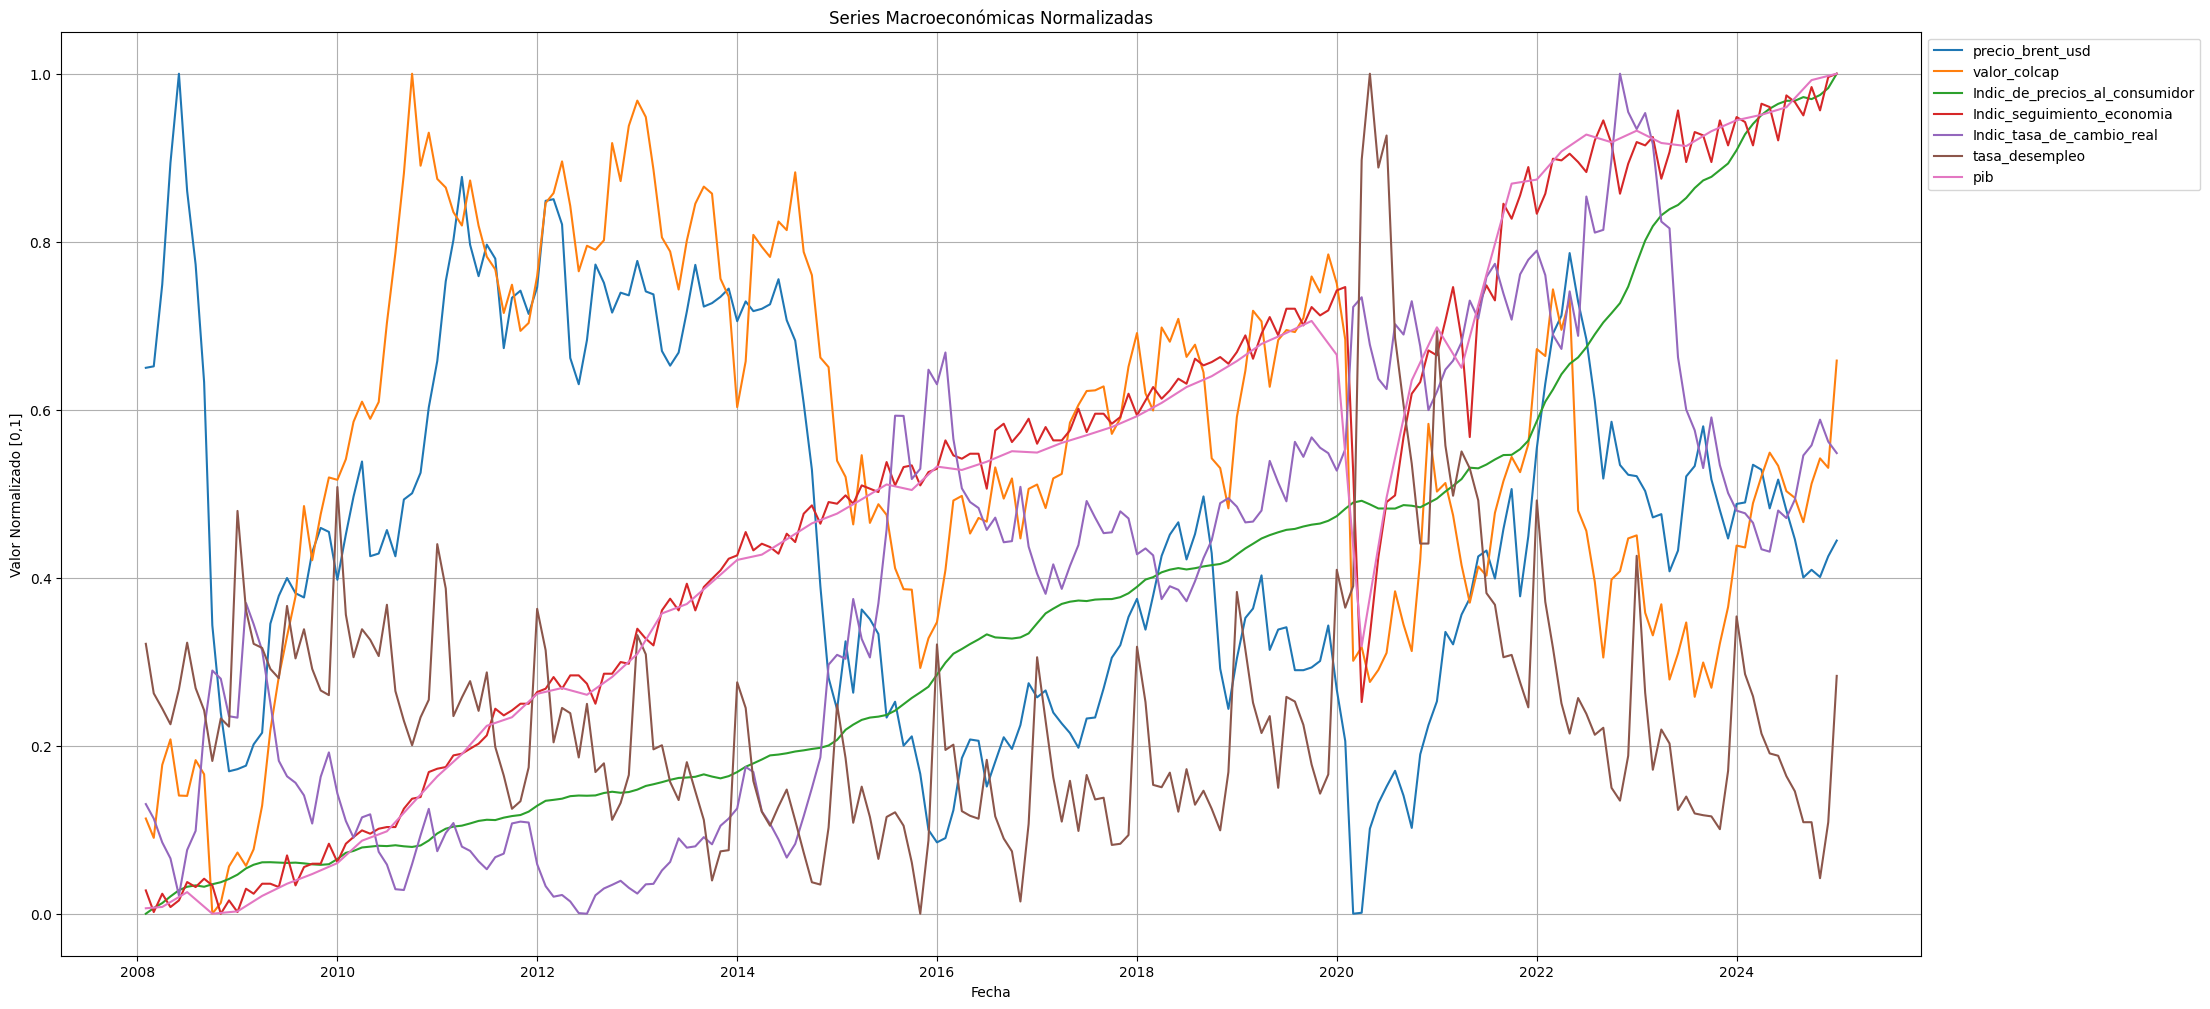

In [7]:
# Gráfica de Datos Normalizados
plt.figure(figsize=(24, 12))

for col in data_norm.columns:
    plt.plot(data_norm.index, data_norm[col], label=col)
plt.title("Series Macroeconómicas Normalizadas")
plt.xlabel("Fecha")
plt.ylabel("Valor Normalizado [0,1]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Time Delay Embedding (Single Embedding)

El Time Delay Embedding es una forma estandar muy utilizada en Análisis Topológico de Datos sobre series de tiempo, en la cual se transforma una serie de tiempo $f(t)$ univariada a una nube de puntos en $\mathbb{R}^{d}$, definiendo una ventana de tiempo de dimensión $d$, un delay $\tau$. Más formalmente, este tipo de transformación se define como una función $TD_{d, \tau}f: \mathbb{R} \to \mathbb{R}^{d}$ donde:

$$
TD_{d,\tau}f(t) =
\begin{pmatrix}
f(t)\\[4pt]
f(t+\tau)\\[4pt]
\vdots\\[4pt]
f\bigl(t+(d-1)\tau\bigr)
\end{pmatrix}
$$

In [8]:
# Definición de parámetros (Arbitrarios)
embedding_dimension = 3   # Tamaño de la ventana de tiempo (d)
embedding_time_delay = 2  # Delay de evaluación (tau)
stride = 1                # Diferencia entre tiempos de evaluación (t_{i+1} - t_i)

### Selección de parámetros

Giotto tiene implementadas internamente funciones que encuentran los parámetros $d$ y $\tau$ óptimos en un rango.

In [9]:
# Definición de parámetros (Optimos)
results = []
for col in data_norm.columns:
    serie = data_norm[col].values
    n = len(serie)
    max_tau = min(30, n // 10)
    max_dim = min(8, n // (2 * max_tau))
    
    tau, dim = takens_embedding_optimal_parameters(
        serie,
        max_time_delay=max_tau,
        max_dimension=max_dim
    )
    results.append((col, tau, dim))

optimal_parameters = pd.DataFrame(results, columns=["Serie", "tau", "d"])
optimal_parameters.set_index("Serie", inplace=True)
print(optimal_parameters)


                                tau  d
Serie                                 
precio_brent_usd                  4  4
valor_colcap                      8  5
Indic_de_precios_al_consumidor   16  4
Indic_seguimiento_economia       13  5
Indic_tasa_de_cambio_real        17  2
tasa_desempleo                    5  5
pib                              19  3


In [10]:
# Single Time Delay Embedding con GTDA
from gtda.time_series import SingleTakensEmbedding

# Función de Embedding TD_d,tau
def embedder_single(tau, d, serie):
    return SingleTakensEmbedding(parameters_type="fixed", n_jobs=-1, time_delay=tau, dimension=d, stride=1).fit_transform(serie)

In [11]:
# Transformación de las series de tiempo
single_embeddings = {}

for col in data_norm.columns:
    serie = data_norm[col].values 

    tau = int(optimal_parameters.loc[col, "tau"])
    d = int(optimal_parameters.loc[col, "d"])

    emb = embedder_single(tau, d, serie)
    single_embeddings[col] = emb

# Verificar dimensiones
for col, emb in single_embeddings.items():
    print(f"{col}: embedding shape = {emb.shape}")

precio_brent_usd: embedding shape = (192, 4)
valor_colcap: embedding shape = (172, 5)
Indic_de_precios_al_consumidor: embedding shape = (156, 4)
Indic_seguimiento_economia: embedding shape = (152, 5)
Indic_tasa_de_cambio_real: embedding shape = (187, 2)
tasa_desempleo: embedding shape = (184, 5)
pib: embedding shape = (166, 3)


In [12]:
# --- Crear la cuadrícula dinámica de subplots ---
n = len(single_embeddings)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

fig = make_subplots(
    rows=rows,
    cols=cols,
    specs=[[{'type': 'scatter3d'} for _ in range(cols)] for _ in range(rows)],
    subplot_titles=list(single_embeddings.keys())
)

# --- Graficar cada embedding ---
for i, (name, arr) in enumerate(single_embeddings.items()):
    # Ajustar dimensionalidad para 3D
    n_points, dim = arr.shape

    if dim < 3:
        # Rellenar con ceros hasta tener 3 dimensiones
        arr_3d = np.hstack([arr, np.zeros((n_points, 3 - dim))])
        subtitle = f"{name} (dim={dim} → 3D)"
    elif dim > 3:
        # Reducir con PCA
        pca = PCA(n_components=3)
        arr_3d = pca.fit_transform(arr)
        explained = np.sum(pca.explained_variance_ratio_)
        subtitle = f"{name} (PCA 3D, var={explained:.2f})"
    else:
        arr_3d = arr
        subtitle = name

    # Posición en la cuadrícula
    r = i // cols + 1
    c = i % cols + 1

    # Añadir la nube 3D
    fig.add_trace(
        go.Scatter3d(
            x=arr_3d[:, 0],
            y=arr_3d[:, 1],
            z=arr_3d[:, 2],
            mode='markers',
            marker=dict(size=3, opacity=0.8),
            name=subtitle
        ),
        row=r, col=c
    )

# --- Ajustes estéticos ---
fig.update_layout(
    height=350 * rows,
    width=350 * cols,
    showlegend=False,
    title_text="Embeddings Takens 3D (tau, d) óptimos — con PCA si aplica",
    margin=dict(l=0, r=0, t=60, b=0),
)

fig.show()


## Time Delay Embedding (MultiTakens Embedding)

La versión MultiTakens de la transformación Time Delay Embedding es una forma se transforma una serie de tiempo $F(t) = \left[f_1(t), ..., f_m(t) \right]$ multivariada a una nube de puntos en $\mathbb{R}^{m \times d}$, definiendo una ventana de tiempo de dimensión $d$, un delay $\tau$. Más formalmente, este tipo de transformación se define como una función $TD_{d, \tau, m}f: \mathbb{R} \to \mathbb{R}^{m \times d}$ donde:

$$
TD_{d,\tau}f(t) =
\begin{pmatrix}
f_1(t)\\[4pt]
f_1(t+\tau)\\[4pt]
\vdots\\[4pt]
f_1\bigl(t+(d-1)\tau\bigr)\\[4pt]
f_2(t)\\[4pt]
\vdots\\[4pt]
f_m(t)\\[4pt]
f_m(t+\tau)\\[4pt]
\vdots\\[4pt]
f_m\bigl(t+(d-1)\tau\bigr)
\end{pmatrix}
$$

En esta transformación se añaden dos parámetros adicionales:
- `flatten` que puede ser `True` si se busca que el resultado quede en un vector que incluya todas las variables indiscriminadamente, o `False` de lo contrario.
- `ensure_last_value` que puede ser `True` si se busca asegurar que se incluya siempre la última observación, sin importar desalineación de los vectores del embedding.

In [13]:
# Definición de parámetros (Multi)
embedding_dimension = 5   # Tamaño de la ventana de tiempo (d)
embedding_time_delay = 11  # Delay de evaluación (tau)
stride = 1                # Diferencia entre tiempos de evaluación (t_{i+1} - t_i)

In [14]:
# Multivariate Time Delay Embedding con GTDA
from gtda.time_series import TakensEmbedding

# Función de Embedding TD_d,tau
def embedder_multi(tau, d, serie):
    return TakensEmbedding(time_delay=tau, dimension=d, stride=1, flatten=True, ensure_last_value=True).fit_transform(serie)

In [15]:
# Transformación del DataFrame (Matriz Single Embeddings)
print("Embedding MultiTakens 3D (Matriz de Single Embeddings):")
X = data_norm.values
print(f"shape de los datos originales: {X.shape}")

# Dimensiones de la tabla original
n_rows, n_series = X.shape

X_emb = embedder_multi(embedding_time_delay, embedding_dimension, X.T)
print(f"Shape del Embedding: {X_emb.shape}")

Embedding MultiTakens 3D (Matriz de Single Embeddings):
shape de los datos originales: (204, 7)
Shape del Embedding: (7, 160, 5)


In [16]:
# Reducir de 7D a 3D original
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)  # (198, 3)

# Graficar
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='lines+markers',
    marker=dict(size=4, opacity=0.8),
    line=dict(width=2),
    name="Matriz Original (PCA)"
))

fig.update_layout(
    title="Proyección PCA (3D) de los datos normalizados originales",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    template='plotly_dark'
)
fig.show()

In [17]:
# Transformación del DataFrame (Concatenación)
print("Embedding MultiTakens 2D (Concatenación):")

n_series, n_windows, n_features = X_emb.shape
print(f"Shape original (3D): {X_emb.shape}")

# --- Concatenar todas las series en un solo vector por ventana ---
X_emb_concat = (
    X_emb                       # (n_series, n_windows, n_features)
    .transpose(1, 0, 2)         # → (n_windows, n_series, n_features)
    .reshape(n_windows, -1)     # → (n_windows, n_series * n_features)
)

print(f"Shape concatenado: {X_emb_concat.shape}")

Embedding MultiTakens 2D (Concatenación):
Shape original (3D): (7, 160, 5)
Shape concatenado: (160, 35)


In [18]:
# Reducir de 21D a 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_emb_concat)  # (198, 3)

# Graficar
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='lines+markers',
    marker=dict(size=4, opacity=0.8),
    line=dict(width=2),
    name="Concatenated embedding (PCA)"
))

fig.update_layout(
    title="Proyección PCA (3D) del Embedding Concatenado",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    template='plotly_dark'
)
fig.show()


## Complejo de Vietori-Rips y Persistencia

Como funciona el tema de los complejos Vietori-Rips y la persistencia en Giotto...

https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html

In [19]:
# Construcción de la filtración sobre el Complejo
from gtda.homology import VietorisRipsPersistence

# 0: componentes, 1: ciclos, 2: cavidades
homology_dimensions = [0, 1, 2]  

VR = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions,
    n_jobs=-1 
)

In [20]:
# Diagrama de persistencia de los datos iniciales sin transformación
X_3d = X[np.newaxis, :, :]   # shape = (1, 204, 7)

diagram_X = VR.fit_transform_plot(X_3d)

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [21]:
# Diagrama de persistencia de cada serie 
diagram_emb = VR.fit_transform(X_emb)

for name, diagram in zip(data_norm.columns, diagram_emb):
    print(f"Diagrama de persistencia para {name}")
    plot_diagram(diagram).show()  

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Diagrama de persistencia para precio_brent_usd


Diagrama de persistencia para valor_colcap


Diagrama de persistencia para Indic_de_precios_al_consumidor


Diagrama de persistencia para Indic_seguimiento_economia


Diagrama de persistencia para Indic_tasa_de_cambio_real


Diagrama de persistencia para tasa_desempleo


Diagrama de persistencia para pib


In [22]:
# Diagrama de persistencia del Embedding con Concatenación
X_emb_concat_3d = X_emb_concat[np.newaxis, :, :]

diagram_concat = VR.fit_transform_plot(X_emb_concat_3d)

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/daniel/venvs/py312-tda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



### Mapper Algorithm

En el contexto del análisis Topológico de Series Económicas, es comunmente usado el algoritmo de Mapper para estudiar la topología intrinseca de las series, además de estudiar anomalías y valores atípicos. En este ejercicio pretendemos evaluar el algoritmo sobre diferentes Embeddings significativos, para así poder evaluar en el contexto qué características Topológicas se mantienen, o si existen anomalías en los datos.

In [187]:
# Data viz
from gtda.plotting import plot_point_cloud

from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import pairwise_distances
from pydiffmap import diffusion_map as dm
from pydiffmap.visualization import embedding_plot, data_plot

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import kmapper as km

In [214]:
# Primer paso, escoger los Embeddings, se escogen entonces cada uno de los embeddings por indicador, su versión concatenada y su versión indexada temporalmente.
X_time_indexed = copy.deepcopy(X)
X_univariate = copy.deepcopy(single_embeddings)
X_concat_emb = copy.deepcopy(X_emb_concat)

In [180]:
def eccentricity(X):
    """
    X: (n_samples, n_features)
    Devuelve un array (n_samples, 1) con la excentricidad de cada punto.
    """
    D = pairwise_distances(X)        # matriz de distancias
    ecc = D.max(axis=1).reshape(-1, 1)
    return ecc

In [198]:
def build_mapper_config(X, n_components=3, name=""):
    """
    Construye los filtros y clusterer listos para KMapper.
    Devuelve un diccionario con:
        - 'pca': PCA(n_components)
        - 'ecc': Eccentricity
        - 'dmap': Diffusion Maps (si posible)
        - 'dbscan': DBSCAN optimizado
        - parámetros adicionales útiles
    """
    result = {}

    # ------------------------
    # 1. PCA
    # ------------------------
    pca = PCA(n_components=n_components)
    result["pca"] = pca.fit_transform(X)

    # ------------------------
    # 2. Eccentricity
    # ------------------------
    result["ecc"] = eccentricity(X)

    # ------------------------
    # 3. Diffusion Maps
    # ------------------------
    dm_ok = False
    dmap_final = None

    # Intento con k automático
    dmap_test = dm.DiffusionMap.from_sklearn(
        n_evecs=n_components,
        k=min(15, len(X)-2),
        epsilon="bgh",
        alpha=1.0,  # podrías ajustar alpha automáticamente si quieres
        neighbor_params={"n_jobs": -1}
    )

    try:
        lens_dmap = dmap_test.fit_transform(X)  
        result["dmap"] = lens_dmap
    except Exception:
        print(f"{name}: No fue posible construir Diffusion Maps.")
        
    # ------------------------
    # 4. DBSCAN
    # ------------------------
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    min_samples = max(4, 2 * n_components)

    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)
    k_dist = np.sort(distances[:, -1])

    knee = KneeLocator(
        range(len(k_dist)),
        k_dist,
        curve="convex",
        direction="increasing"
    )

    eps_opt = knee.knee_y if knee.knee_y is not None else float(np.percentile(k_dist, 85))
    dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples)

    result["dbscan"] = dbscan
    result["eps_opt"] = eps_opt
    result["min_samples"] = min_samples

    return result

Uso de las transformaciones para cada Embedding

In [ ]:
# Para el embedding indexado por tiempo
transform_X_indexed = build_mapper_config(X_time_indexed, n_components=1, name="Time_indexed")

# Para el embedding concatenado
transform_X_concat = build_mapper_config(X_concat_emb, n_components=1, name="Concat")

# Para los embeddings univariados
transformers_X_univ = {
    var: build_mapper_config(X_univariate[var], n_components=1, name=var)
    for var in X_univariate
}

Indic_seguimiento_economia: No fue posible construir Diffusion Maps.
Indic_tasa_de_cambio_real: No fue posible construir Diffusion Maps.
tasa_desempleo: No fue posible construir Diffusion Maps.
pib: No fue posible construir Diffusion Maps.


Definimos los intervalos de cubrimiento

In [203]:
def build_cover_kmapper(X):
    n = len(X)
    
    if n < 2000:
        return km.Cover(n_cubes=8, perc_overlap=0.3)
    elif n < 10000:
        return km.Cover(n_cubes=12, perc_overlap=0.35)
    else:
        return km.Cover(n_cubes=20, perc_overlap=0.4)

In [205]:
cover_X_indexed = build_cover_kmapper(X_time_indexed)
cover_X_concat = build_cover_kmapper(X_concat_emb)
cover_X_univar = {k: build_cover_kmapper(X_univariate[k]) for k in X_univariate}

Por último, construimos cada uno de los Grafos de Mapper con dichos transformadores, y los visualizamos

In [206]:
# Embedding indexado
mapper = km.KeplerMapper(verbose=1)
X_ind_mapper = {}

print(type(transform_X_indexed["pca"]))
X_ind_mapper["PCA"] = mapper.map(transform_X_indexed["pca"], X_time_indexed, cover=cover_X_indexed, clusterer=transform_X_indexed["dbscan"])
X_ind_mapper["ECC"] = mapper.map(transform_X_indexed["ecc"], X_time_indexed, cover=cover_X_indexed, clusterer=transform_X_indexed["dbscan"])
X_ind_mapper["DMP"] = mapper.map(transform_X_indexed["dmap"], X_time_indexed, cover=cover_X_indexed, clusterer=transform_X_indexed["dbscan"])

KeplerMapper(verbose=1)
<class 'numpy.ndarray'>
Mapping on data shaped (204, 7) using lens shaped (204, 1)

Creating 8 hypercubes.

Created 9 edges and 11 nodes in 0:00:00.022762.
Mapping on data shaped (204, 7) using lens shaped (204, 1)

Creating 8 hypercubes.

Created 14 edges and 18 nodes in 0:00:00.011182.
Mapping on data shaped (204, 7) using lens shaped (204, 1)

Creating 8 hypercubes.

Created 0 edges and 2 nodes in 0:00:00.009016.


Se visualizan en la página web de KMapper

In [237]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def visualize_temporal_cycles_with_diffmaps(data_norm, X_array, mapper_output, 
                                             diffmap_coords, filter_name='DMP',
                                             title='Ciclos Temporales Macroeconómicos'):
    """
    Visualiza ciclos temporales con Diffusion Maps y grafo Mapper
    
    Parameters:
    - data_norm: DataFrame original con fechas como índice
    - X_array: numpy array (X_time_indexed)
    - mapper_output: resultado de mapper.fit_transform()
    - diffmap_coords: coordenadas de Diffusion Maps (dmap del config)
    - filter_name: 'DMP', 'PCA', o 'ECC'
    """
    
    # Extraer fechas
    dates = pd.to_datetime(data_norm.index)
    
    # Mapeo de nodos
    node_ids = list(mapper_output['nodes'].keys())
    node_to_int = {node_id: i for i, node_id in enumerate(node_ids)}
    
    # Asignar nodo a cada fecha
    node_assignment = np.full(len(dates), -1)
    node_labels = np.full(len(dates), 'Sin nodo', dtype=object)
    
    for node_id, indices in mapper_output['nodes'].items():
        node_assignment[indices] = node_to_int[node_id]
        node_labels[indices] = node_id
    
    # Estadísticas por nodo
    node_stats = {}
    for node_id, indices in mapper_output['nodes'].items():
        if len(indices) > 0:
            node_dates = dates[indices]
            node_stats[node_id] = {
                'size': len(indices),
                'first_date': node_dates.min(),
                'last_date': node_dates.max(),
                'indices': indices,
                'avg_date': node_dates.min() + (node_dates.max() - node_dates.min()) / 2
            }
    
    # Crear figura
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Timeline: Asignación de Nodos (2008-2025)',
            'Trayectoria en Diffusion Maps (coloreada por tiempo)',
            'Distribución Temporal de Nodos',
            'Ciclo Anual: Nodo Dominante por Mes',
            'Transiciones entre Nodos',
            'Persistencia Temporal de Nodos'
        ),
        specs=[
            [{"colspan": 2}, None],
            [{"type": "scatter"}, {"type": "scatterpolar"}],
            [{"type": "bar"}, {"type": "scatter"}]
        ],
        vertical_spacing=0.08,
        horizontal_spacing=0.12,
        row_heights=[0.25, 0.35, 0.4]
    )
    
    # ===== SUBPLOT 1: Timeline completo (2008-2025) =====
    fig.add_trace(
        go.Scatter(
            x=dates,
            y=node_assignment,
            mode='markers',
            marker=dict(
                size=6,
                color=node_assignment,
                colorscale='Viridis',
                line=dict(width=0.3, color='white'),
                opacity=0.8,
                showscale=True,
                colorbar=dict(
                    title="Nodo ID",
                    len=0.25,
                    y=0.88
                )
            ),
            text=[f"<b>{dates[i].strftime('%Y-%m-%d')}</b><br>Nodo: {node_labels[i]}<br>ID: {node_assignment[i]}" 
                  for i in range(len(dates))],
            hovertemplate='%{text}<extra></extra>',
            name='Nodo asignado',
            showlegend=False
        ),
        row=1, col=1
    )
    
    # Líneas de conexión para mostrar continuidad
    fig.add_trace(
        go.Scatter(
            x=dates,
            y=node_assignment,
            mode='lines',
            line=dict(color='rgba(150,150,150,0.3)', width=1),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=1, col=1
    )
    
    # Marcar crisis económicas conocidas (opcional)
    crisis_periods = [
        {'start': '2008-09-01', 'end': '2009-06-01', 'name': 'Crisis Financiera 2008'},
        {'start': '2020-03-01', 'end': '2020-12-01', 'name': 'COVID-19'}
    ]
    
    for crisis in crisis_periods:
        fig.add_vrect(
            x0=crisis['start'], x1=crisis['end'],
            fillcolor="red", opacity=0.1,
            layer="below", line_width=0,
            annotation_text=crisis['name'],
            annotation_position="top left",
            annotation=dict(font_size=9),
            row=1, col=1
        )
    
    # ===== SUBPLOT 2: Trayectoria en Diffusion Maps =====
    if diffmap_coords is not None and diffmap_coords.shape[1] >= 2:
        X_2d = diffmap_coords[:, :2]
        
        # Color por tiempo (gradiente temporal)
        time_numeric = (dates - dates.min()).days.values
        
        fig.add_trace(
            go.Scatter(
                x=X_2d[:, 0],
                y=X_2d[:, 1],
                mode='markers',
                marker=dict(
                    size=5,
                    color=time_numeric,
                    colorscale='Plasma',
                    showscale=True,
                    colorbar=dict(
                        title="Días<br>desde<br>2008",
                        len=0.3,
                        y=0.45,
                        x=0.46
                    ),
                    line=dict(width=0.3, color='white'),
                    opacity=0.7
                ),
                text=[f"<b>{dates[i].strftime('%Y-%m')}</b><br>Nodo: {node_labels[i]}" 
                      for i in range(len(dates))],
                hovertemplate='%{text}<extra></extra>',
                name='Trayectoria',
                showlegend=False
            ),
            row=2, col=1
        )
        
        # Línea de trayectoria temporal (conectar cronológicamente)
        fig.add_trace(
            go.Scatter(
                x=X_2d[:, 0],
                y=X_2d[:, 1],
                mode='lines',
                line=dict(color='rgba(200,200,200,0.3)', width=0.8),
                showlegend=False,
                hoverinfo='skip'
            ),
            row=2, col=1
        )
        
        # Marcar inicio y fin
        fig.add_trace(
            go.Scatter(
                x=[X_2d[0, 0], X_2d[-1, 0]],
                y=[X_2d[0, 1], X_2d[-1, 1]],
                mode='markers+text',
                marker=dict(size=15, color=['green', 'red'], 
                           symbol=['circle', 'square'],
                           line=dict(width=2, color='white')),
                text=['2008', '2025'],
                textposition='top center',
                textfont=dict(size=10, color='black'),
                name='Inicio/Fin',
                showlegend=True
            ),
            row=2, col=1
        )
    
    # ===== SUBPLOT 3: Ciclo Anual =====
    # Calcular nodo dominante por mes (agregando todos los años)
    months = dates.month
    month_node_dominant = {}
    
    for month in range(1, 13):
        month_mask = months == month
        if month_mask.any():
            nodes_in_month = node_assignment[month_mask]
            valid_nodes = nodes_in_month[nodes_in_month != -1]
            if len(valid_nodes) > 0:
                # Calcular moda
                unique, counts = np.unique(valid_nodes, return_counts=True)
                month_node_dominant[month] = unique[counts.argmax()]
            else:
                month_node_dominant[month] = -1
    
    month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                   'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    month_values = [month_node_dominant.get(m, -1) for m in range(1, 13)]
    month_values_display = [v if v != -1 else 0 for v in month_values]
    
    fig.add_trace(
        go.Scatterpolar(
            r=month_values_display,
            theta=month_names,
            mode='lines+markers',
            marker=dict(size=12, color=month_values_display, 
                       colorscale='Viridis', showscale=False),
            line=dict(color='rgba(100,100,100,0.6)', width=2),
            fill='toself',
            fillcolor='rgba(100,100,200,0.2)',
            name='Nodo dominante',
            showlegend=False,
            hovertemplate='<b>%{theta}</b><br>Nodo dominante: %{r}<extra></extra>'
        ),
        row=2, col=2
    )
    
    # ===== SUBPLOT 4: Distribución temporal (timeline de cada nodo) =====
    for node_id, stats in sorted(node_stats.items(), 
                                  key=lambda x: x[1]['first_date']):
        node_num = node_to_int[node_id]
        
        fig.add_trace(
            go.Bar(
                x=[stats['first_date'], stats['last_date']],
                y=[node_id, node_id],
                orientation='h',
                marker=dict(
                    color=node_num,
                    colorscale='Viridis',
                    showscale=False
                ),
                width=0.6,
                text=f"n={stats['size']}",
                textposition='inside',
                name=node_id,
                showlegend=False,
                hovertemplate=f"<b>{node_id}</b><br>Inicio: {stats['first_date'].strftime('%Y-%m-%d')}<br>Fin: {stats['last_date'].strftime('%Y-%m-%d')}<br>Tamaño: {stats['size']}<extra></extra>"
            ),
            row=3, col=1
        )
    
    # ===== SUBPLOT 5: Matriz de transiciones =====
    # Calcular transiciones entre nodos consecutivos
    transitions = {}
    for i in range(1, len(node_assignment)):
        if node_assignment[i-1] != -1 and node_assignment[i] != -1:
            from_node = node_assignment[i-1]
            to_node = node_assignment[i]
            key = (from_node, to_node)
            transitions[key] = transitions.get(key, 0) + 1
    
    # Crear matriz de transiciones
    n_nodes = len(node_ids)
    transition_matrix = np.zeros((n_nodes, n_nodes))
    
    for (from_n, to_n), count in transitions.items():
        if from_n < n_nodes and to_n < n_nodes:
            transition_matrix[from_n, to_n] = count
    
    # Normalizar por fila (probabilidades de transición)
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_probs = np.divide(transition_matrix, row_sums, 
                                  where=row_sums!=0, 
                                  out=np.zeros_like(transition_matrix))
    
    # Grafo de transiciones (mostrar las principales)
    top_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:15]
    
    edge_x = []
    edge_y = []
    edge_text = []
    
    # Posicionar nodos en círculo para el grafo
    angles = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
    node_pos = {i: (np.cos(a), np.sin(a)) for i, a in enumerate(angles)}
    
    for (from_n, to_n), count in top_transitions:
        if from_n in node_pos and to_n in node_pos:
            x0, y0 = node_pos[from_n]
            x1, y1 = node_pos[to_n]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_text.append(f"{count} transiciones")
    
    if edge_x:
        fig.add_trace(
            go.Scatter(
                x=edge_x,
                y=edge_y,
                mode='lines',
                line=dict(color='rgba(125,125,125,0.4)', width=1),
                hoverinfo='skip',
                showlegend=False
            ),
            row=3, col=2
        )
    
    # Nodos
    node_x = [node_pos[i][0] for i in range(n_nodes)]
    node_y = [node_pos[i][1] for i in range(n_nodes)]
    node_sizes = [stats['size'] for _, stats in sorted(node_stats.items(), 
                                                        key=lambda x: node_to_int[x[0]])]
    
    fig.add_trace(
        go.Scatter(
            x=node_x,
            y=node_y,
            mode='markers+text',
            marker=dict(
                size=np.sqrt(node_sizes)*3,
                color=list(range(n_nodes)),
                colorscale='Viridis',
                showscale=False,
                line=dict(width=2, color='white')
            ),
            text=[f"N{i}" for i in range(n_nodes)],
            textposition='middle center',
            textfont=dict(size=8, color='white'),
            hovertext=[f"Nodo {i}<br>Tamaño: {size}" 
                      for i, size in enumerate(node_sizes)],
            hovertemplate='%{hovertext}<extra></extra>',
            showlegend=False
        ),
        row=3, col=2
    )
    
    # Actualizar layouts
    fig.update_xaxes(title_text="Fecha", row=1, col=1)
    fig.update_yaxes(title_text="Nodo ID", row=1, col=1)
    
    fig.update_xaxes(title_text="DiffMap Dim 1", row=2, col=1)
    fig.update_yaxes(title_text="DiffMap Dim 2", row=2, col=1)
    
    fig.update_xaxes(title_text="Período Temporal", row=3, col=1)
    fig.update_yaxes(title_text="Nodo", row=3, col=1)
    
    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=3, col=2)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=3, col=2)
    
    fig.update_layout(
        title_text=f"{title}<br><sub>Filtro: {filter_name} | Período: 2008-2025 | {len(node_ids)} nodos</sub>",
        height=1200,
        width=1400,
        showlegend=True,
        hovermode='closest'
    )
    
    return fig, node_stats, transition_matrix

# ====== USO ======
# Primero obtener las coordenadas de Diffusion Maps del config
config_indexed = build_mapper_config(X_time_indexed, n_components=3, name="Time_Indexed")

# Crear visualización
fig_cycles, stats, trans_matrix = visualize_temporal_cycles_with_diffmaps(
    data_norm=data_norm,
    X_array=X_time_indexed,
    mapper_output=X_ind_mapper["PCA"],
    diffmap_coords=config_indexed["pca"],  # Coordenadas de Diffusion Maps
    filter_name='PCA',
    title='Análisis de Ciclos Temporales: Macroeconomía Colombiana'
)

fig_cycles.show()

# Imprimir análisis de ciclos
print("\n" + "="*60)
print("ANÁLISIS DE CICLOS TEMPORALES")
print("="*60)

for node_id, stat in sorted(stats.items(), key=lambda x: x[1]['first_date']):
    print(f"\n{node_id}:")
    print(f"  📊 Tamaño: {stat['size']} observaciones")
    print(f"  📅 Período: {stat['first_date'].strftime('%Y-%m-%d')} → {stat['last_date'].strftime('%Y-%m-%d')}")
    years = (stat['last_date'] - stat['first_date']).days / 365.25
    print(f"  ⏱️  Duración: {years:.1f} años")

print("\n" + "="*60)
print("MATRIZ DE TRANSICIONES (Top 10)")
print("="*60)
transitions_list = []
for i in range(trans_matrix.shape[0]):
    for j in range(trans_matrix.shape[1]):
        if trans_matrix[i, j] > 0:
            transitions_list.append((i, j, trans_matrix[i, j]))

for from_n, to_n, count in sorted(transitions_list, key=lambda x: x[2], reverse=True)[:10]:
    print(f"Nodo {from_n} → Nodo {to_n}: {int(count)} transiciones")


ANÁLISIS DE CICLOS TEMPORALES

cube0_cluster0:
  📊 Tamaño: 8 observaciones
  📅 Período: 2008-02-01 → 2008-09-01
  ⏱️  Duración: 0.6 años

cube0_cluster1:
  📊 Tamaño: 34 observaciones
  📅 Período: 2008-10-01 → 2011-08-01
  ⏱️  Duración: 2.8 años

cube1_cluster0:
  📊 Tamaño: 9 observaciones
  📅 Período: 2008-10-01 → 2009-07-01
  ⏱️  Duración: 0.7 años

cube1_cluster1:
  📊 Tamaño: 36 observaciones
  📅 Período: 2010-11-01 → 2013-10-01
  ⏱️  Duración: 2.9 años

cube2_cluster0:
  📊 Tamaño: 20 observaciones
  📅 Período: 2013-04-01 → 2014-11-01
  ⏱️  Duración: 1.6 años

cube3_cluster0:
  📊 Tamaño: 10 observaciones
  📅 Período: 2014-10-01 → 2015-07-01
  ⏱️  Duración: 0.7 años

cube4_cluster0:
  📊 Tamaño: 46 observaciones
  📅 Período: 2015-07-01 → 2019-04-01
  ⏱️  Duración: 3.8 años

cube5_cluster0:
  📊 Tamaño: 29 observaciones
  📅 Período: 2018-10-01 → 2021-06-01
  ⏱️  Duración: 2.7 años

cube4_cluster1:
  📊 Tamaño: 5 observaciones
  📅 Período: 2020-04-01 → 2020-08-01
  ⏱️  Duración: 0.3 años


In [247]:
# Time_Indexed con PCA
mapper.visualize(
    X_ind_mapper["PCA"],
    path_html="mapper_indexed_pca.html",
    title="Mapper Graph Time_Indexed (PCA filter)"
)

# Time_Indexed con Eccentricity
mapper.visualize(
    X_ind_mapper["ECC"],
    path_html="mapper_indexed_ecc.html",
    title="Mapper Graph Time_Indexed (ECC filter)"
)

# Time_Indexed con Diffusion Maps
mapper.visualize(
    X_ind_mapper["DMP"],
    path_html="mapper_indexed_diffmaps.html",
    title="Mapper Graph Time_Indexed (DiffMap filter)"
)

Wrote visualization to: mapper_indexed_pca.html
Wrote visualization to: mapper_indexed_ecc.html
Wrote visualization to: mapper_indexed_diffmaps.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper Graph Time_Indexed (DiffMap filter) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  f

---

In [215]:
# Embedding Concat
mapper = km.KeplerMapper(verbose=1)
X_concat_mapper = {}

X_concat_mapper["PCA"] = mapper.map(transform_X_concat["pca"], X_concat_emb, cover=cover_X_concat, clusterer=transform_X_concat["dbscan"])
X_concat_mapper["ECC"] = mapper.map(transform_X_concat["ecc"], X_concat_emb, cover=cover_X_concat, clusterer=transform_X_concat["dbscan"])
X_concat_mapper["DMP"] = mapper.map(transform_X_concat["dmap"], X_concat_emb, cover=cover_X_concat, clusterer=transform_X_concat["dbscan"])

KeplerMapper(verbose=1)
Mapping on data shaped (160, 35) using lens shaped (160, 1)

Creating 8 hypercubes.

Created 8 edges and 12 nodes in 0:00:00.024188.
Mapping on data shaped (160, 35) using lens shaped (160, 1)

Creating 8 hypercubes.

Created 11 edges and 18 nodes in 0:00:00.010544.
Mapping on data shaped (160, 35) using lens shaped (160, 1)

Creating 8 hypercubes.

Created 1 edges and 5 nodes in 0:00:00.010387.


In [232]:
# Time_Indexed con PCA
mapper.visualize(
    X_concat_mapper["PCA"],
    path_html="mapper_concat_pca.html",
    title="Mapper Graph Concat (PCA filter)"
)

# Time_Indexed con Eccentricity
mapper.visualize(
    X_concat_mapper["ECC"],
    path_html="mapper_concat_ecc.html",
    title="Mapper Graph Concat (ECC filter)"
)

# Time_Indexed con Diffusion Maps
mapper.visualize(
    X_concat_mapper["DMP"],
    path_html="mapper_concat_diffmaps.html",
    title="Mapper Graph Concat (DiffMap filter)"
)

Wrote visualization to: mapper_concat_pca.html
Wrote visualization to: mapper_concat_ecc.html
Wrote visualization to: mapper_concat_diffmaps.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper Graph Concat (DiffMap filter) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-si

---

In [239]:
# Embedding Univariate

mapper_X_univ = {}
mapper = km.KeplerMapper(verbose=1)

for var in X_univariate:

    mapper_X_univ[var] = {}

    tr = transformers_X_univ[var]       
    cover = cover_X_univar[var]         
    clusterer = tr["dbscan"]            

    # --- PCA ---
    mapper_X_univ[var]["PCA"] = mapper.map(tr["pca"], X_univariate[var], cover=cover, clusterer=clusterer)

    # --- ECC ---
    mapper_X_univ[var]["ECC"] = mapper.map(tr["ecc"], X_univariate[var], cover=cover, clusterer=clusterer)

    # --- DMP (solo si existe en transformers) ---
    if tr.get("dmap", None) is not None:
        mapper_X_univ[var]["DMP"] = mapper.map(tr["dmap"], X_univariate[var], cover=cover, clusterer=clusterer)

KeplerMapper(verbose=1)
Mapping on data shaped (192, 4) using lens shaped (192, 1)

Creating 8 hypercubes.

Created 7 edges and 9 nodes in 0:00:00.014297.
Mapping on data shaped (192, 4) using lens shaped (192, 1)

Creating 8 hypercubes.

Created 14 edges and 15 nodes in 0:00:00.010543.
Mapping on data shaped (192, 4) using lens shaped (192, 1)

Creating 8 hypercubes.

Created 0 edges and 1 nodes in 0:00:00.002268.
Mapping on data shaped (172, 5) using lens shaped (172, 1)

Creating 8 hypercubes.

Created 11 edges and 12 nodes in 0:00:00.011074.
Mapping on data shaped (172, 5) using lens shaped (172, 1)

Creating 8 hypercubes.

Created 11 edges and 14 nodes in 0:00:00.010479.
Mapping on data shaped (172, 5) using lens shaped (172, 1)

Creating 8 hypercubes.

Created 2 edges and 5 nodes in 0:00:00.005582.
Mapping on data shaped (156, 4) using lens shaped (156, 1)

Creating 8 hypercubes.

Created 7 edges and 8 nodes in 0:00:00.006503.
Mapping on data shaped (156, 4) using lens shaped (15

In [248]:
for var in X_univariate:
    for lens_type, graph in mapper_X_univ[var].items():
        # Nombre del archivo HTML
        html_path = f"{var}_{lens_type}.html"
        
        # Título para la visualización
        title = f"Mapper - {var} - {lens_type}"
        
        # Guardar HTML interactivo
        mapper.visualize(
            graph,
            path_html=html_path,
            title=title
        )
        
        print(f"[OK] Guardado {html_path}")


Wrote visualization to: precio_brent_usd_PCA.html
[OK] Guardado precio_brent_usd_PCA.html
Wrote visualization to: precio_brent_usd_ECC.html
[OK] Guardado precio_brent_usd_ECC.html
Wrote visualization to: precio_brent_usd_DMP.html
[OK] Guardado precio_brent_usd_DMP.html
Wrote visualization to: valor_colcap_PCA.html
[OK] Guardado valor_colcap_PCA.html
Wrote visualization to: valor_colcap_ECC.html
[OK] Guardado valor_colcap_ECC.html
Wrote visualization to: valor_colcap_DMP.html
[OK] Guardado valor_colcap_DMP.html
Wrote visualization to: Indic_de_precios_al_consumidor_PCA.html
[OK] Guardado Indic_de_precios_al_consumidor_PCA.html
Wrote visualization to: Indic_de_precios_al_consumidor_ECC.html
[OK] Guardado Indic_de_precios_al_consumidor_ECC.html
Wrote visualization to: Indic_de_precios_al_consumidor_DMP.html
[OK] Guardado Indic_de_precios_al_consumidor_DMP.html
Wrote visualization to: Indic_seguimiento_economia_PCA.html
[OK] Guardado Indic_seguimiento_economia_PCA.html
Wrote visualization 